## Mapping California Air Quality Data

### Air Quality EDA

Here we perform an EDA of air quality data from the Environmental Protection Agency (EPA). Data is obtained for California counties for the years 1990, 1995, ..., 2020. It includes information on the per-year number of "Good Days", "Moderate Days", and so on. Here we define a new variable as the **"Total Unhealthy Days"**, which is the sum of Unhealthy for Sensitive Groups Days, Unhealthy Days, Very UnHealthy Days and Hazardous Days recorded in air quality data. Information on the daily air quality index (AQI) that determines its category can be investigated on the EPA's website.

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import folium
import osmnx as ox
import matplotlib.pyplot as plt

In [2]:
file_paths = ["annual_aqi_by_county_1990.csv", "annual_aqi_by_county_1995.csv", "annual_aqi_by_county_2000.csv", "annual_aqi_by_county_2005.csv", "annual_aqi_by_county_2010.csv", 
              "annual_aqi_by_county_2015.csv", "annual_aqi_by_county_2020.csv"]

In [3]:
#LOAD and FILTER CA DATA

# Load data for each year
years = [1990, 1995, 2000, 2005, 2010, 2015, 2020]
dfs = {year: pd.read_csv(f'annual_aqi_by_county_{year}.csv') for year in years}

# Select California data only
#CA_dfs = {year: df[df['State'] == 'California'] for year, df in dfs.items

CA_dfs = {year: df[df['State'] == 'California'].copy() for year, df in dfs.items()}

# Compute the Total Unhealthy Days in each data set and add as new column
for year, df in CA_dfs.items():
    df['Total Unhealthy Days'] = df[['Unhealthy for Sensitive Groups Days','Unhealthy Days','Very Unhealthy Days','Hazardous Days']].sum(axis=1)

    #print(f"Data for {year} (California only):")
    #print(df.head(), "\n")

    #Check the number of rows per year (i.e. the number of Counties, this will inform if counties have changed since 1990)
    print(f"Year {year}: {df.shape[0]} rows, {df.shape[1]} columns")



Year 1990: 51 rows, 19 columns
Year 1995: 54 rows, 19 columns
Year 2000: 56 rows, 19 columns
Year 2005: 53 rows, 19 columns
Year 2010: 53 rows, 19 columns
Year 2015: 54 rows, 19 columns
Year 2020: 53 rows, 19 columns


In [4]:
# GET STATISTICS OF EACH DF (FOR EACH YEAR)
# Create a dictionary to hold the mean of air quality metrics for each year
CA_summary_stats_per_year = {}

# Loop through the CA_dfs dictionary to calculate and print summary statistics and mean metrics
for year, df in CA_dfs.items():
    #print(f"CA summary statistics for {year}:")
    #print(df.describe())
    #print("\n")
    
    # Extract the mean row from df.describe()
    #summary_stats_per_year[year] = df.describe().loc['mean']
    CA_summary_stats_per_year[year] = df.describe()
    
    print(f"Data for {year} (California only):")
    print(CA_summary_stats_per_year[year].head(), "\n")


Data for 1990 (California only):
         Year  Days with AQI   Good Days  Moderate Days  \
count    51.0      51.000000   51.000000      51.000000   
mean   1990.0     305.627451  183.588235      74.470588   
std       0.0     103.872799  101.135587      49.733431   
min    1990.0      56.000000   17.000000       4.000000   
25%    1990.0     267.500000   92.000000      37.500000   

       Unhealthy for Sensitive Groups Days  Unhealthy Days  \
count                            51.000000       51.000000   
mean                             27.686275       12.294118   
std                              31.507136       19.435323   
min                               0.000000        0.000000   
25%                               1.500000        0.000000   

       Very Unhealthy Days  Hazardous Days     Max AQI  90th Percentile AQI  \
count             51.00000       51.000000   51.000000            51.000000   
mean               7.45098        0.137255  185.705882            99.666667   
st

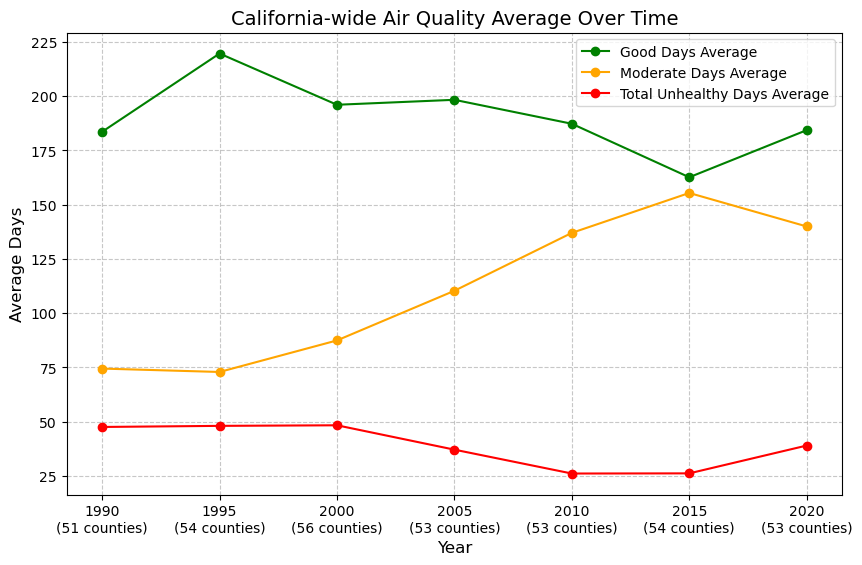

In [5]:
# PLOT California-wide Air Quality Average TIME SERIES

# Extract years and the average metrics for Good Days, Moderate Days, and Total Unhealthy Days
years = list(CA_summary_stats_per_year.keys())
good_days_avg = [CA_summary_stats_per_year[year].loc["mean", "Good Days"] for year in years]
moderate_days_avg = [CA_summary_stats_per_year[year].loc["mean", "Moderate Days"] for year in years]
unhealthy_days_avg = [CA_summary_stats_per_year[year].loc["mean", "Total Unhealthy Days"] for year in years]

num_counties = [int(CA_summary_stats_per_year[year].loc["count", "Year"]) for year in years]

# Plot the averages over time
plt.figure(figsize=(10, 6))

plt.plot(years, good_days_avg, marker='o', label="Good Days Average", color = 'green')
plt.plot(years, moderate_days_avg, marker='o', label="Moderate Days Average", color = 'orange')
plt.plot(years, unhealthy_days_avg, marker='o', label="Total Unhealthy Days Average", color = 'red')

# Add titles and labels
plt.title("California-wide Air Quality Average Over Time", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Average Days", fontsize=12)
# x-axis label
#plt.xticks(years)  # Ensure years are displayed as ticks
# custom x-axis labels: "Year\nCounty Count"
custom_labels = [f"{year}\n({count} counties)" for year, count in zip(years, num_counties)]
plt.xticks(years, labels=custom_labels, rotation=0, ha="center")
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend()

#Save plot
#plt.savefig("CA_AirQuality_TimeSeriesPlot.png", dpi=300, bbox_inches="tight", format="png")

# Show the plot
#plt.tight_layout()
#plt.show()



Note: CA has 58 counties since 1907. Difference in number of county recordings are likely due to missing data. CA-wide averages per year above may be slightly bias due to missing some counties data. 

What counties are missing/different accross the data for each year?

In [6]:
# Create a list of Counties
counties_per_year = {year: set(df["County"].unique()) for year, df in CA_dfs.items()}
CA_counties = set().union(*counties_per_year.values())  

missing_counties = {
    year: CA_counties - counties  # Find counties missing in each year
    for year, counties in counties_per_year.items()
}

# Print missing counties per year
for year, missing in missing_counties.items():
    print(f"Counties missing in {year}: {missing}")

Counties missing in 1990: {'Calaveras', 'Trinity', 'Amador', 'Sierra', 'Alpine', 'Modoc', 'Lassen'}
Counties missing in 1995: {'Alpine', 'Yuba', 'Sierra', 'Lassen'}
Counties missing in 2000: {'Alpine', 'Yuba'}
Counties missing in 2005: {'Sierra', 'Alpine', 'Yuba', 'Modoc', 'Lassen'}
Counties missing in 2010: {'Sierra', 'Alpine', 'Yuba', 'Modoc', 'Lassen'}
Counties missing in 2015: {'Modoc', 'Yuba', 'Sierra', 'Lassen'}
Counties missing in 2020: {'Sierra', 'Alpine', 'Yuba', 'Modoc', 'Lassen'}


In [7]:
# Find the intersection of all county sets (counties that appear in every year)
consistent_counties = set.intersection(*counties_per_year.values())

# Create a new dictionary with only consistent counties
CA_dfs_norm = {
    year: df[df["County"].isin(consistent_counties)].copy()  # .copy() avoids SettingWithCopyWarning
    for year, df in CA_dfs.items()
}

In [8]:
# GET STATISTICS OF EACH DF (FOR EACH YEAR)
# Create a dictionary to hold the mean of air quality metrics for each year
CA_norm_summary_stats_per_year = {}

# Loop through the CA_dfs dictionary to calculate and print summary statistics and mean metrics
for year, df in CA_dfs_norm.items():
    #print(f"CA summary statistics for {year}:")
    #print(df.describe())
    #print("\n")
    
    # Extract the mean row from df.describe()
    #summary_stats_per_year[year] = df.describe().loc['mean']
    CA_norm_summary_stats_per_year[year] = df.describe()
    
    print(f"Data for {year} (California only):")
    print(CA_norm_summary_stats_per_year[year].head(), "\n")

Data for 1990 (California only):
         Year  Days with AQI   Good Days  Moderate Days  \
count    50.0      50.000000   50.000000      50.000000   
mean   1990.0     310.560000  186.200000      75.840000   
std       0.0      98.709667  100.409976      49.257491   
min    1990.0      56.000000   17.000000       4.000000   
25%    1990.0     297.250000  103.500000      38.250000   

       Unhealthy for Sensitive Groups Days  Unhealthy Days  \
count                            50.000000       50.000000   
mean                             28.240000       12.540000   
std                              31.575346       19.552347   
min                               0.000000        0.000000   
25%                               2.250000        0.000000   

       Very Unhealthy Days  Hazardous Days     Max AQI  90th Percentile AQI  \
count            50.000000       50.000000   50.000000            50.000000   
mean              7.600000        0.140000  188.160000           100.620000   
st

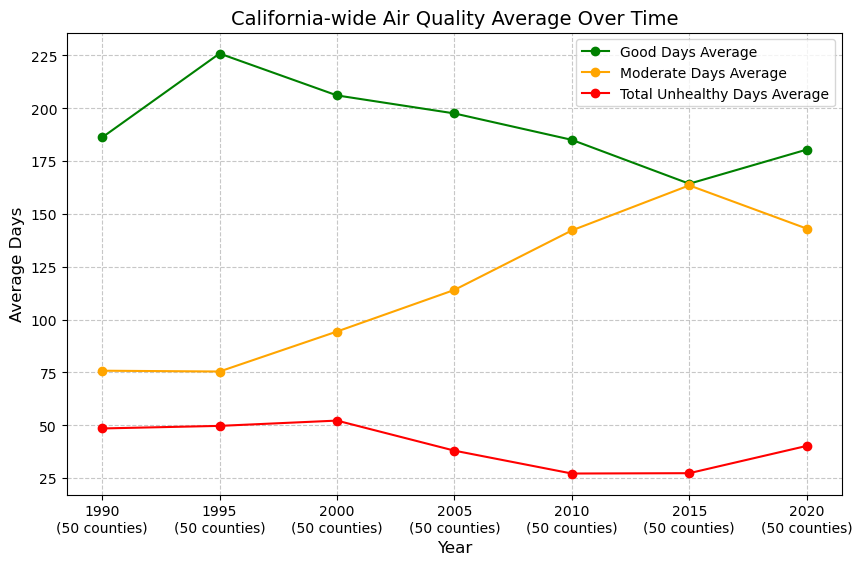

In [9]:
#Plot NEW California-wide Air Quality Average Time Series

# Extract years and the average metrics for Good Days, Moderate Days, and Total Unhealthy Days
years = list(CA_norm_summary_stats_per_year.keys())
good_days_avg = [CA_norm_summary_stats_per_year[year].loc["mean", "Good Days"] for year in years]
moderate_days_avg = [CA_norm_summary_stats_per_year[year].loc["mean", "Moderate Days"] for year in years]
unhealthy_days_avg = [CA_norm_summary_stats_per_year[year].loc["mean", "Total Unhealthy Days"] for year in years]

num_counties = [int(CA_norm_summary_stats_per_year[year].loc["count", "Year"]) for year in years]

# Plot the averages over time
plt.figure(figsize=(10, 6))

plt.plot(years, good_days_avg, marker='o', label="Good Days Average", color = 'green')
plt.plot(years, moderate_days_avg, marker='o', label="Moderate Days Average", color = 'orange')
plt.plot(years, unhealthy_days_avg, marker='o', label="Total Unhealthy Days Average", color = 'red')

# Add titles and labels
plt.title("California-wide Air Quality Average Over Time", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Average Days", fontsize=12)
# x-axis label
#plt.xticks(years)  # Ensure years are displayed as ticks
# custom x-axis labels: "Year\nCounty Count"
custom_labels = [f"{year}\n({count} counties)" for year, count in zip(years, num_counties)]
plt.xticks(years, labels=custom_labels, rotation=0, ha="center")
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend()

#Save plot
#plt.savefig("CA_norm_AirQuality_TimeSeriesPlot.png", dpi=300, bbox_inches="tight", format="png")

# Show the plot
#plt.tight_layout()
#plt.show()

In [10]:
# Get summary statistics for each county averaged over time

# Combine all DataFrames in CA_dfs dictionary into a single DataFrame
# Omitting _norm subscript from this point on.
CA_df_30yr_span = pd.concat(CA_dfs_norm.values(), ignore_index=True)
CA_df_30yr_span.head()

,State,County,Year,Days with AQI,Good Days,Moderate Days,Unhealthy for Sensitive Groups Days,Unhealthy Days,Very Unhealthy Days,Hazardous Days,Max AQI,90th Percentile AQI,Median AQI,Days CO,Days NO2,Days Ozone,Days PM2.5,Days PM10,Total Unhealthy Days
0,California,Alameda,1990,365,265,87,9,4,0,0,200,79,38,6,185,167,0,7,13
1,California,Butte,1990,365,251,96,17,1,0,0,174,77,40,67,104,182,0,12,18
2,California,Colusa,1990,73,66,7,0,0,0,0,70,49,31,0,0,0,0,73,0
3,California,Contra Costa,1990,365,261,93,6,5,0,0,200,71,44,21,140,200,0,4,11
4,California,Del Norte,1990,340,330,10,0,0,0,0,67,43,30,0,0,303,37,0,0


Note: Not all counties have recordings for every day of the year ('Days with AQI' column)

In [11]:
CA_df_30yr_span.shape

(350, 19)

In [12]:
#Compute averages and create plot

# Compute average over time for each county
# Drop non numeric column
CA_df_30yr_span = CA_df_30yr_span.drop(columns=['State'])

county_avg_over_time = CA_df_30yr_span.groupby(['County']).mean()

county_avg_over_time.head()

,Year,Days with AQI,Good Days,Moderate Days,Unhealthy for Sensitive Groups Days,Unhealthy Days,Very Unhealthy Days,Hazardous Days,Max AQI,90th Percentile AQI,Median AQI,Days CO,Days NO2,Days Ozone,Days PM2.5,Days PM10,Total Unhealthy Days
County,,,,,,,,,,,,,,,,,
Alameda,2005.0,365.285714,212.000000,139.000000,9.428571,4.000000,0.857143,0.000000,192.714286,75.428571,46.571429,1.571429,73.285714,135.000000,153.714286,1.714286,14.285714
Butte,2005.0,364.571429,197.285714,141.857143,20.857143,3.857143,0.428571,0.285714,207.857143,92.142857,47.857143,16.428571,35.857143,214.571429,91.714286,6.000000,25.428571
Colusa,2005.0,321.285714,205.857143,105.285714,6.285714,3.571429,0.285714,0.000000,144.857143,69.142857,42.000000,0.000000,0.000000,167.571429,118.571429,35.142857,10.142857
Contra Costa,2005.0,365.285714,242.142857,109.714286,10.000000,3.000000,0.428571,0.000000,176.714286,73.000000,44.000000,3.428571,49.428571,189.428571,121.428571,1.571429,13.428571
Del Norte,2005.0,200.285714,180.857143,18.142857,0.571429,0.428571,0.285714,0.000000,88.000000,41.857143,24.428571,0.000000,0.000000,74.857143,110.000000,15.428571,1.285714


In [13]:
county_avg_over_time.tail()

,Year,Days with AQI,Good Days,Moderate Days,Unhealthy for Sensitive Groups Days,Unhealthy Days,Very Unhealthy Days,Hazardous Days,Max AQI,90th Percentile AQI,Median AQI,Days CO,Days NO2,Days Ozone,Days PM2.5,Days PM10,Total Unhealthy Days
County,,,,,,,,,,,,,,,,,
Tehama,2005.0,316.428571,186.000000,100.428571,23.571429,6.142857,0.285714,0.0,171.000000,101.571429,44.857143,0.000000,0.000000,246.714286,57.428571,12.285714,30.000000
Tulare,2005.0,365.285714,79.857143,152.857143,83.285714,47.000000,2.285714,0.0,203.571429,158.142857,80.428571,2.428571,28.714286,213.000000,114.285714,6.857143,132.571429
Tuolumne,2005.0,340.714286,236.000000,78.142857,21.857143,4.714286,0.000000,0.0,158.285714,90.428571,42.571429,3.000000,0.000000,337.714286,0.000000,0.000000,26.571429
Ventura,2005.0,365.285714,154.142857,144.000000,42.857143,19.000000,5.285714,0.0,190.285714,124.571429,58.571429,0.000000,33.428571,261.142857,68.285714,2.428571,67.142857
Yolo,2005.0,364.857143,242.714286,106.714286,11.571429,3.714286,0.142857,0.0,156.857143,78.000000,43.285714,7.285714,9.142857,232.000000,111.285714,5.142857,15.428571


Text(0.5, 1.0, 'Average Total Unhealthy Days per California County (1990-2020)')

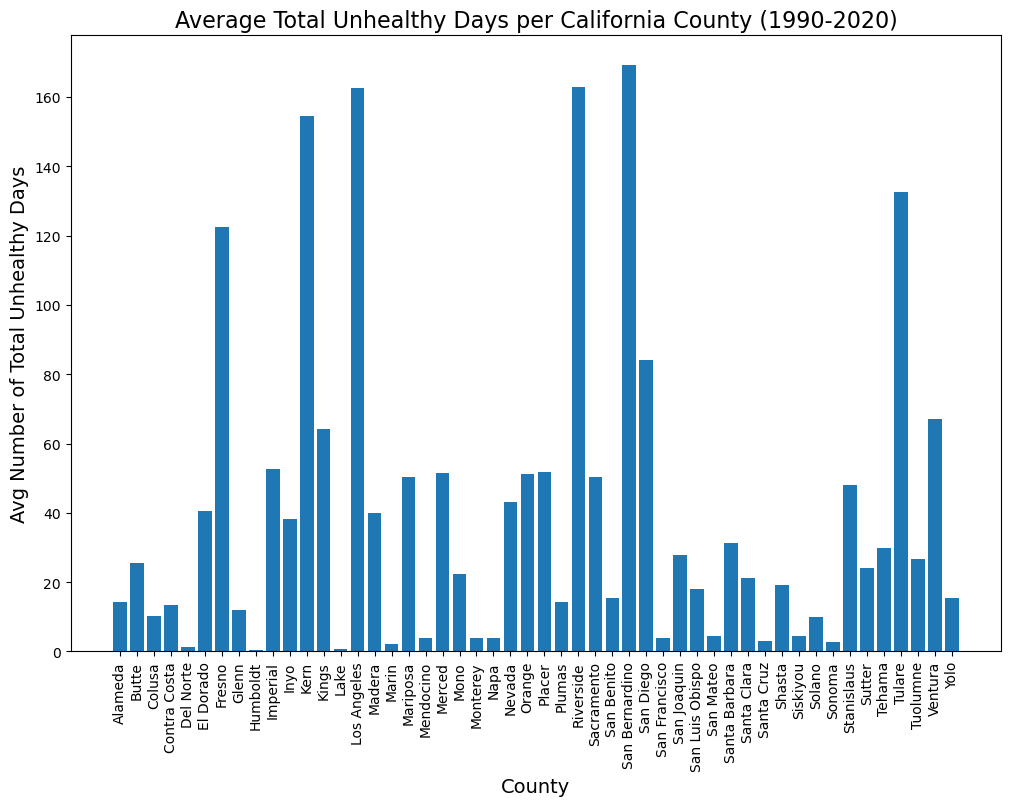

In [14]:
# Create bar plot for the average number of Total Unhealthy Days in each county for the span 1990 - 2020

fig, ax = plt.subplots(figsize=(12, 8))

# Rotate x-axis labels to vertical
plt.xticks(rotation=90) 
#bar_labels = CA_df_30yr_span['County'].unique()
#bar_colors = ['tab:red', 'tab:blue', 'tab:red', 'tab:orange']

ax.bar(county_avg_over_time.index, county_avg_over_time['Total Unhealthy Days'])

ax.set_xlabel('County', fontsize=14)
ax.set_ylabel('Avg Number of Total Unhealthy Days', fontsize=14)
ax.set_title('Average Total Unhealthy Days per California County (1990-2020)', fontsize=16)
#ax.legend(title='Average Total Unhealthy Days per California County (1990-2020)', fontsize=16)

#Save plot
#plt.savefig("CA_norm_AvgTotalUnhealthyDays_perCounty.png", dpi=300, bbox_inches="tight", format="png")

#plt.tight_layout()
#plt.show()


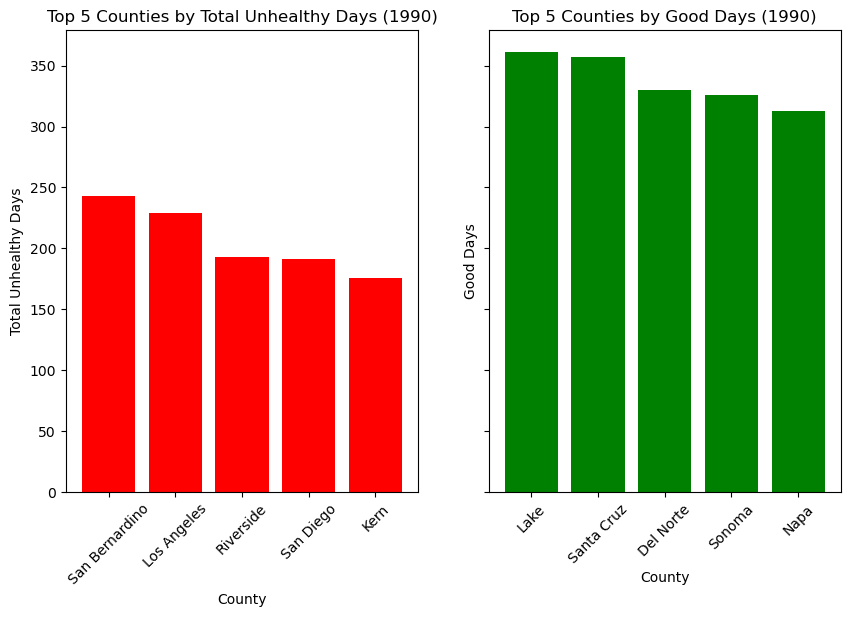

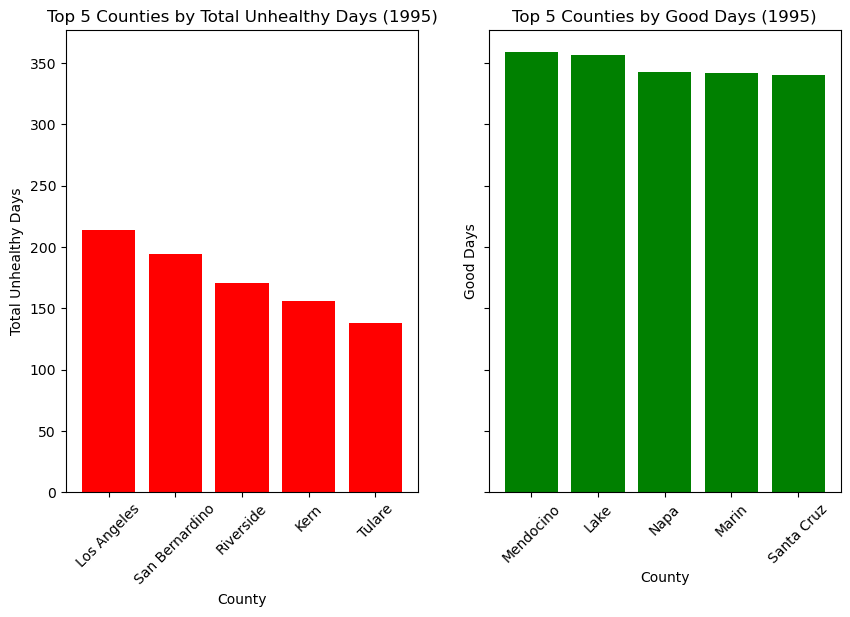

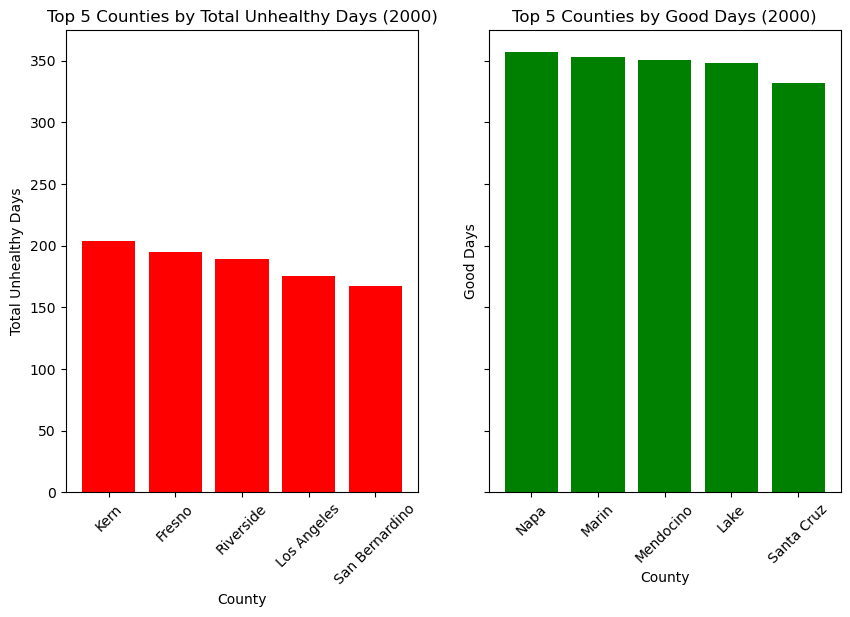

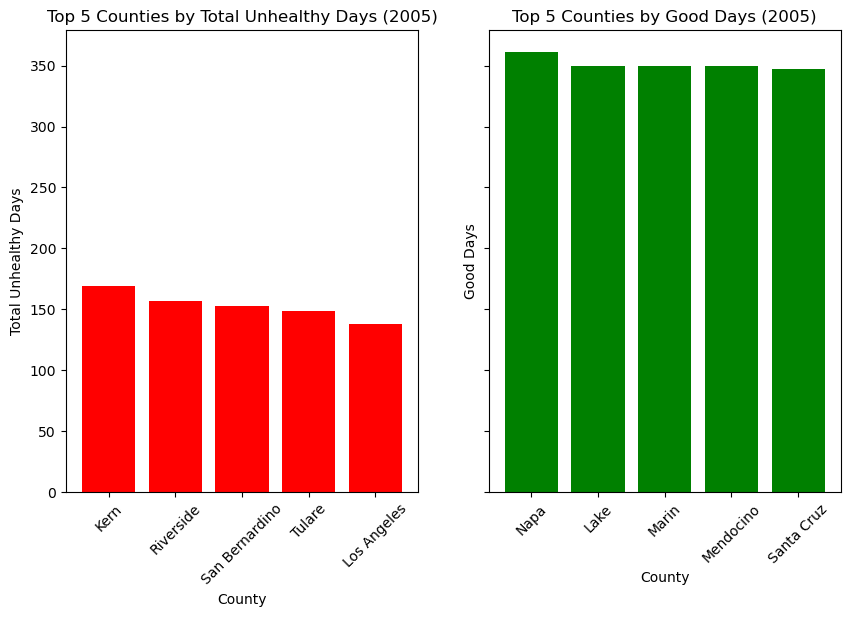

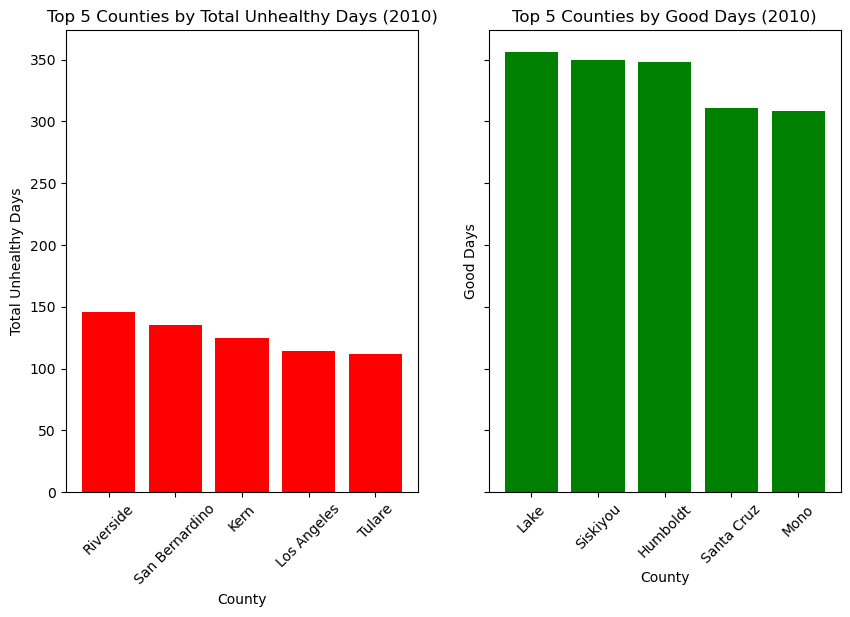

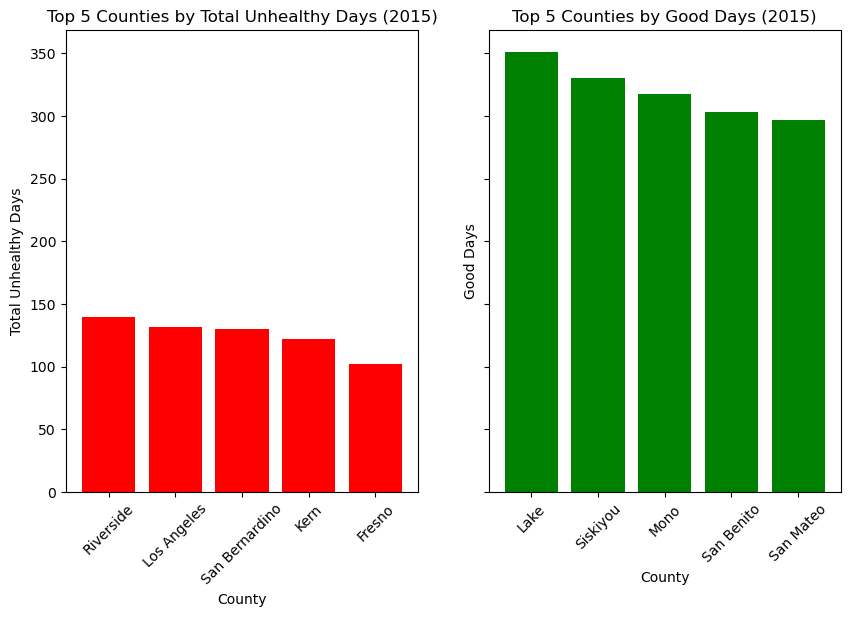

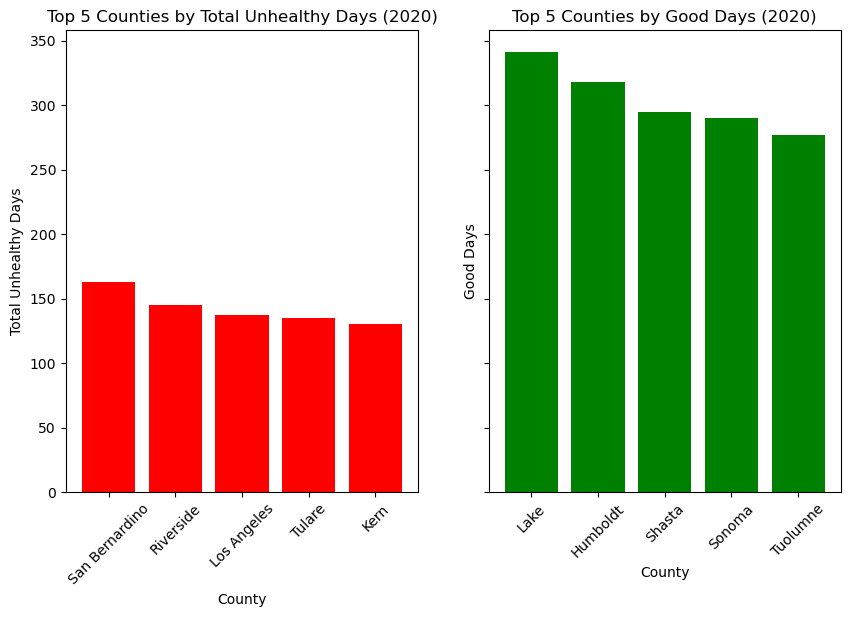

In [15]:
#Plot top and bottom 5 counties in terms of Air Quality (most Good Days and Total Bad Days)

# Loop through each year in the DataFrame
for year, df in CA_df_30yr_span.groupby("Year"):
    # Find top 5 counties for Total Unhealthy Days
    top_unhealthy = df.nlargest(5, "Total Unhealthy Days")
    
    # Find top 5 counties for Good Days
    top_good = df.nlargest(5, "Good Days")
    
    # Create a subplot figure
    fig, axes = plt.subplots(1, 2, figsize=(10, 6), sharey=True)

    # Plot for Total Unhealthy Days
    axes[0].bar(top_unhealthy["County"], top_unhealthy["Total Unhealthy Days"], color="red")
    axes[0].set_title(f"Top 5 Counties by Total Unhealthy Days ({year})")
    axes[0].set_xlabel("County")
    axes[0].set_ylabel("Total Unhealthy Days")
    axes[0].tick_params(axis='x', rotation=45)

    # Plot for Good Days
    axes[1].bar(top_good["County"], top_good["Good Days"], color="green")
    axes[1].set_title(f"Top 5 Counties by Good Days ({year})")
    axes[1].set_xlabel("County")
    axes[1].set_ylabel("Good Days")
    axes[1].tick_params(axis='x', rotation=45)
    
    #Save plot
    #plt.savefig(f"CA_AirQuality_TopBestWorstCounties_{year}.png", dpi=300, bbox_inches="tight", format="png")

    # Adjust layout and show the plot
    #plt.tight_layout()
    #plt.show()
    
    

### Map Data

#### Get California County Boundary Data

In [16]:
# PRODUCE and SAVE CALIFORNIA COUNTY BOUNDARY MAP

# Load U.S. county boundaries dataset from github repository plotly/datasets with FIPS codes as identifier
#url = "https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json"
#us_counties = gpd.read_file(url)

# Filter for California counties
#CA_county_bndries = us_counties[us_counties['STATE'] == '06']  # '06' is California's FIPS code
#ca_counties = us_counties[us_counties['STATE'] == '06']  # '06' is California's FIPS code

# Save California counties to a new GeoJSON file
#CA_county_bndries.to_file("CA_county_bndries.geojson", driver="GeoJSON")

#CA_county_bndries.head()

In [2]:
#Since I saved the CA boundaries data into a GeoJSON, I can simply upload and skip running the cell above
CA_county_bndries = gpd.read_file("CA_county_bndries.geojson")
CA_county_bndries.head()

,id,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,geometry
0,06005,0500000US06005,06,005,Amador,County,594.583,"POLYGON ((-120.9955 38.2254, -121.02708 38.300..."
1,06021,0500000US06021,06,021,Glenn,County,1313.947,"POLYGON ((-122.93765 39.79816, -122.04647 39.7..."
2,06033,0500000US06033,06,033,Lake,County,1256.464,"POLYGON ((-122.6274 38.66751, -122.82159 38.85..."
3,06043,0500000US06043,06,043,Mariposa,County,1448.816,"POLYGON ((-120.38767 37.63336, -120.38733 37.6..."
4,06055,0500000US06055,06,055,Napa,County,748.362,"POLYGON ((-122.10328 38.51335, -122.08884 38.3..."


In [3]:
#Check CRS
print(CA_county_bndries.crs)

EPSG:4326


In [4]:
print(CA_county_bndries.__geo_interface__.keys())

dict_keys(['type', 'features', 'bbox'])


In [20]:
#print(CA_county_bndries.__geo_interface__)

In [21]:
# Map CA county boundaries

from folium import GeoJson

# Set CRS
#CA_county_bndries = CA_county_bndries.to_crs(epsg=4326)

# Initialize a Folium map centered on California
CA_county_map = folium.Map(location=[37.5, -119.5], zoom_start=6)


# Styling for the county boundaries
style_function = lambda x: {
    "fillColor": "none",  # Transparent fill
    "color": "#ff7f50",  # Coral for the outline
    "weight": 2,  # Outline thickness
    "fillOpacity": 0.1  # Transparent fill
}

# Add county boundaries to the map with tooltips and the updated style
county_geojson = folium.GeoJson(
    CA_county_bndries,
    #CA_county_bndries.to_json(),  # Convert GeoDataFrame to GeoJSON
    name="CA County Boundaries",
    style_function=style_function,
)

county_geojson.add_to(CA_county_map)

#OLD
# Add county boundaries to the map

#folium.GeoJson(
#    CA_county_bndries.to_json(),  # Convert GeoDataFrame to GeoJSON
#    name="CA County Boundaries",
#    style_function=lambda x: {
#        "fillColor": "none",  # Transparent fill
#        "color": "black",
#        "weight": 1
#    }
#).add_to(CA_county_map)

# Add layer control to toggle between layers
folium.LayerControl().add_to(CA_county_map)

#CA_county_map.save("CA_county_map.html")

# Display the map
#CA_county_map

#### Link Air Quality Data to County Boundary Data

In [22]:
# LINK AirQuality (AQ) yearly data to CA county boundaries.

CA_AQ_df_1990 = CA_df_30yr_span[CA_df_30yr_span['Year']==1990]
print(CA_AQ_df_1990.shape)
print(CA_county_bndries.shape)

(50, 18)
(58, 8)


In [23]:
# Merge AQ CSV file with CA county boundaries geojson file
# Make sure both DataFrames have a matching column to join on
# For example, if `df.csv` has 'County' and `gdf.gjson` has 'NAME' columns for county name data, merge on those columns 

# Merge the two dataframes on the county name (adjust as per your column names)
merged_df_1990 = CA_county_bndries.merge(CA_AQ_df_1990, left_on="NAME", right_on="County")

print(merged_df_1990.shape)

merged_df_1990.head()

(50, 26)


,id,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,geometry,County,Year,...,Hazardous Days,Max AQI,90th Percentile AQI,Median AQI,Days CO,Days NO2,Days Ozone,Days PM2.5,Days PM10,Total Unhealthy Days
0,06021,0500000US06021,06,021,Glenn,County,1313.947,"POLYGON ((-122.93765 39.79816, -122.04647 39.7...",Glenn,1990,...,0,151,101,33,0,0,152,0,43,21
1,06033,0500000US06033,06,033,Lake,County,1256.464,"POLYGON ((-122.6274 38.66751, -122.82159 38.85...",Lake,1990,...,0,77,40,27,29,0,335,0,1,0
2,06043,0500000US06043,06,043,Mariposa,County,1448.816,"POLYGON ((-120.38767 37.63336, -120.38733 37.6...",Mariposa,1990,...,0,177,126,49,0,0,336,9,17,71
3,06055,0500000US06055,06,055,Napa,County,748.362,"POLYGON ((-122.10328 38.51335, -122.08884 38.3...",Napa,1990,...,0,105,57,33,43,119,182,0,13,1
4,06089,0500000US06089,06,089,Shasta,County,3775.402,"POLYGON ((-123.06543 40.28697, -123.06879 40.3...",Shasta,1990,...,0,205,87,43,1,50,300,1,13,30


In [24]:
#MAP AQ DATA (Total Unhealthy Days) per CA COUNTY over the years 1990,2000,2010,2020

max_tuds = CA_AQ_df_1990["Total Unhealthy Days"].max()
# Create a base Folium map centered on California
m1 = folium.Map(location=[37.5, -119.5], zoom_start=6)

# Add county boundaries to the map with merged data

folium.GeoJson(
    CA_county_bndries,
    #CA_county_bndries.to_json(),  # Convert GeoDataFrame to GeoJSON
    name="CA County Boundaries",
    style_function=style_function,
).add_to(m1)


folium.Choropleth(
    #geo_data=merged_df,  # Use merged GeoDataFrame
    geo_data=merged_df_1990,
    data=merged_df_1990,
    columns=["County", "Total Unhealthy Days"],  # Adjust to columns in your CSV
    key_on="feature.properties.NAME",  # This should match the GeoDataFrame's county column
    #bins=[0, 5, 10, 15, 20, 25, 30, max_vuds],
    bins=[0, 30, 60, 90, 120, max_tuds],
    fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Number of Total Unhealthy Days per year (1990)"
).add_to(m1)

#m1

#m1.save("CA_AirQualityMap_1990.html")

In [25]:
CA_AQ_df_2000 = CA_df_30yr_span[CA_df_30yr_span['Year']==2000]

max_tuds = CA_AQ_df_2000["Total Unhealthy Days"].max()

# Merge the two dataframes on the county name (adjust as per your column names)
merged_df_2000 = CA_county_bndries.merge(CA_AQ_df_2000 , left_on="NAME", right_on="County")

m2 = folium.Map(location=[37.5, -119.5], zoom_start=6)

# Add county boundaries to the map with merged data

folium.GeoJson(
    CA_county_bndries,
    #CA_county_bndries.to_json(),  # Convert GeoDataFrame to GeoJSON
    name="CA County Boundaries",
    style_function=style_function,
).add_to(m2)


folium.Choropleth(
    #geo_data=merged_df,  # Use merged GeoDataFrame
    geo_data=merged_df_2000,
    data=merged_df_2000,
    columns=["County", "Total Unhealthy Days"],  # Adjust to columns in your CSV
    key_on="feature.properties.NAME",  # This should match the GeoDataFrame's county column
    #bins=[0, 5, 10, 15, 20, 25, 30, max_vuds],
    bins=[0, 30, 60, 90, 120, max_tuds],
    fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Number of Total Unhealthy Days per year (2000)"
).add_to(m2)


#m2.save("CA_AirQualityMap_2000.html")

#m2


In [26]:
CA_AQ_df_2010 = CA_df_30yr_span[CA_df_30yr_span['Year']==2010]

max_tuds = CA_AQ_df_2010["Total Unhealthy Days"].max()

# Merge the two dataframes on the county name (adjust as per your column names)
merged_df_2010 = CA_county_bndries.merge(CA_AQ_df_2010 , left_on="NAME", right_on="County")

m3 = folium.Map(location=[37.5, -119.5], zoom_start=6)

# Add county boundaries to the map with merged data

folium.GeoJson(
    CA_county_bndries,
    #CA_county_bndries.to_json(),  # Convert GeoDataFrame to GeoJSON
    name="CA County Boundaries",
    style_function=style_function,
).add_to(m3)


folium.Choropleth(
    #geo_data=merged_df,  # Use merged GeoDataFrame
    geo_data=merged_df_2010,
    data=merged_df_2010,
    columns=["County", "Total Unhealthy Days"],  # Adjust to columns in your CSV
    key_on="feature.properties.NAME",  # This should match the GeoDataFrame's county column
    #bins=[0, 5, 10, 15, 20, 25, 30, max_vuds],
    bins=[0, 30, 60, 90, 120, max_tuds],
    fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Number of Total Unhealthy Days per year (2010)"
).add_to(m3)


#m3.save("CA_AirQualityMap_2010.html")

#m3

In [27]:
CA_AQ_df_2020 = CA_df_30yr_span[CA_df_30yr_span['Year']==2020]

max_tuds = CA_AQ_df_2020["Total Unhealthy Days"].max()

# Merge the two dataframes on the county name (adjust as per your column names)
merged_df_2020 = CA_county_bndries.merge(CA_AQ_df_2020 , left_on="NAME", right_on="County")

m4 = folium.Map(location=[37.5, -119.5], zoom_start=6)

# Add county boundaries to the map with merged data

folium.GeoJson(
    CA_county_bndries,
    #CA_county_bndries.to_json(),  # Convert GeoDataFrame to GeoJSON
    name="CA County Boundaries",
    style_function=style_function,
).add_to(m4)


folium.Choropleth(
    #geo_data=merged_df,  # Use merged GeoDataFrame
    geo_data=merged_df_2020,
    data=merged_df_2020,
    columns=["County", "Total Unhealthy Days"],  # Adjust to columns in your CSV
    key_on="feature.properties.NAME",  # This should match the GeoDataFrame's county column
    #bins=[0, 5, 10, 15, 20, 25, 30, max_vuds],
    bins=[0, 30, 60, 90, 120, max_tuds],
    fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Number of Total Unhealthy Days per year (2020)"
).add_to(m4)


#m4.save("CA_AirQualityMap_2020.html")

#m4